In [102]:
import pandas as pd
from LLM_tags_predictor import ask_ollama, compute_jaccard, TAG_VOCAB
import pickle
from sklearn.metrics import jaccard_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import time

In [103]:
data = pd.read_pickle('data/data_170125.pkl')
data = data.sample(150)

data.head()

Id  Score  ViewCount  AnswerCount         CreationDate  \
41373  65540389      0        356            1  2021-01-02 14:48:42   
9410   69178271      0         97            2  2021-09-14 12:59:42   
15952  69358643      1       2275            1  2021-09-28 08:54:22   
7237   69116380      0       1205            1  2021-09-09 10:15:56   
10339  69203610      0        175            1  2021-09-16 06:51:50   

      clean_tags  \
41373     [java]   
9410      [html]   
15952     [java]   
7237    [python]   
10339  [android]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [104]:
data.shape

(150, 8)

In [105]:

# Charger le MultiLabelBinarizer
mlb = pickle.load(open("mlb_use.pkl", "rb"))
TAG_VOCAB = mlb.classes_.tolist()

# Itérer sur le dataset et prédire les tags
predicted_tags_list = []
jaccard_scores = []
f1_scores = []

# Pour calculs finaux
all_y_true = []
all_y_pred = []

for idx, row in tqdm(data.iterrows(), total=len(data)):
    question = row['cleaned_title_body']
    true_tags = row['clean_tags']

    try:
        pred_tags = ask_ollama(question, TAG_VOCAB)
        predicted_tags_list.append(pred_tags)

        # Binariser les tags pour la ligne
        y_true_bin = mlb.transform([true_tags])
        y_pred_bin = mlb.transform([pred_tags])

        # Stocker pour calcul global
        all_y_true.append(y_true_bin[0])
        all_y_pred.append(y_pred_bin[0])

        # Jaccard score par question
        jaccard_scores.append(jaccard_score(y_true_bin, y_pred_bin, average='samples'))

        # F1 score par question
        f1_scores.append(f1_score(y_true_bin, y_pred_bin, average='samples', zero_division=0))

        time.sleep(1.5)  # éviter surcharge serveur Ollama
    except Exception as e:
        predicted_tags_list.append([])
        jaccard_scores.append(0.0)
        f1_scores.append(0.0)
        print(f"⚠️ Erreur à l’index {idx} : {e}")

# Ajouter les résultats au dataframe
data['predicted_tags'] = predicted_tags_list
data['jaccard_score'] = jaccard_scores
data['f1_score'] = f1_scores

c:\Users\mathi\miniconda3\envs\pytorch\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 150/150 [14:02<00:00,  5.62s/it]


In [106]:
# Conversion en array pour calcul global
import numpy as np
y_true_array = np.array(all_y_true)
y_pred_array = np.array(all_y_pred)

# Moyennes globales
mean_jaccard = jaccard_score(y_true_array, y_pred_array, average='samples')
mean_f1 = f1_score(y_true_array, y_pred_array, average='samples', zero_division=0)

print(f"\n✅ Moyenne Jaccard score (échantillons) : {mean_jaccard:.4f}")
print(f"✅ Moyenne F1 score (échantillons) : {mean_f1:.4f}")


✅ Moyenne Jaccard score (échantillons) : 0.6497
✅ Moyenne F1 score (échantillons) : 0.7145


In [107]:
# Jaccard par tag
jaccard_by_tag = jaccard_score(y_true_array, y_pred_array, average=None)
jaccard_tag_df = pd.DataFrame({'tag': TAG_VOCAB, 'jaccard_score': jaccard_by_tag})
print("\n📊 Jaccard score par tag :")
print(jaccard_tag_df.sort_values(by='jaccard_score', ascending=False))


📊 Jaccard score par tag :
          tag  jaccard_score
8      python       0.814815
0     android       0.800000
2         css       0.666667
7      pandas       0.652174
6     node.js       0.590909
9     reactjs       0.531250
4        java       0.463415
3        html       0.454545
5  javascript       0.425532
1      arrays       0.320000


In [108]:
# F1 score par tag (à utiliser avec prudence si certains tags sont rares)
f1_by_tag = f1_score(y_true_array, y_pred_array, average=None, zero_division=0)
f1_tag_df = pd.DataFrame({'tag': TAG_VOCAB, 'f1_score': f1_by_tag})
print("\n📊 F1 score par tag (⚠️ sensible aux classes rares) :")
print(f1_tag_df.sort_values(by='f1_score', ascending=False))


📊 F1 score par tag (⚠️ sensible aux classes rares) :
          tag  f1_score
8      python  0.897959
0     android  0.888889
2         css  0.800000
7      pandas  0.789474
6     node.js  0.742857
9     reactjs  0.693878
4        java  0.633333
3        html  0.625000
5  javascript  0.597015
1      arrays  0.484848


In [109]:
pd.set_option('display.max_colwidth', 50)
data.head()

,Id,Score,ViewCount,AnswerCount,CreationDate,clean_tags,cleaned_title_body,use_embedding,predicted_tags,jaccard_score,f1_score
41373,65540389,0,356,1,2021-01-02 14:48:42,[java],classloader failed locating my properties file...,"[0.0048554507, 0.059991304, 0.0037320948, -0.0...",[java],1.0,1.0
9410,69178271,0,97,2,2021-09-14 12:59:42,[html],my input file date format changes on daily bas...,"[-0.0760977, -0.034530003, -0.04957246, 0.0436...",[java],0.0,0.0
15952,69358643,1,2275,1,2021-09-28 08:54:22,[java],javanetconnectexception operation timed out co...,"[-0.04345558, 0.058617216, -0.0546204, -0.0421...",[java],1.0,1.0
7237,69116380,0,1205,1,2021-09-09 10:15:56,[python],add liveness probe to rest api pi have a rest ...,"[-0.043955952, -0.023151936, -0.05438789, -0.0...",[python],1.0,1.0
10339,69203610,0,175,1,2021-09-16 06:51:50,[android],constraining a edittext view to a checkbox pro...,"[-0.053296525, -0.064408325, 0.015093507, 0.02...",[android],1.0,1.0


In [110]:
# On change les options pandas pour afficher tout le texte
pd.set_option('display.max_colwidth', None)  # désactive le troncage des colonnes texte
jaccard_null = data.loc[(data['jaccard_score'] == 0) & (data['clean_tags'].apply(lambda tags: 'html' in tags)), ['cleaned_title_body', 'clean_tags']]
jaccard_null.head()

,cleaned_title_body,clean_tags
9410,my input file date format changes on daily basis pi need help please my codeinputfilecode changes on daily basis which gets generated and store under codetmpcode directory file format date as followsp\nprecodetmp\n570572 sep 13 2102 sessions_record_20210913_210052csv\n570788 sep 14 0901 sessions_record_20210914_090041csv\ncodepre\npim not sure how to pick it up as an input file instead of hardcoded in my scriptp\npre classlangperl prettyprintoverridecode#usrbinperl\n\nuse strict use warnings\nuse tiearraycsv\nuse datadumper\nuse dateparse\nuse posix qwstrftime\n\nmy hours 1\nmy timenow time\nmy inputfile quotsessions_record_20210914_090041csvquot\n\ntie my sessions_record tiearraycsv inputfile \n tie_file gt recsep gt quotrnquot \n text_csv gt binary gt 1 \n\n\ntie my incidentidlist tiearraycsv incidentidlistcsv\n\nincidentidlist map \n _4 as+ _4 _18 timenow \nstr2time_18 60 60\n grep \n _0 serviceinc ampamp timenow str2time_18 60 60 gt hours \n sessions_record\ncodepre\n,[html]


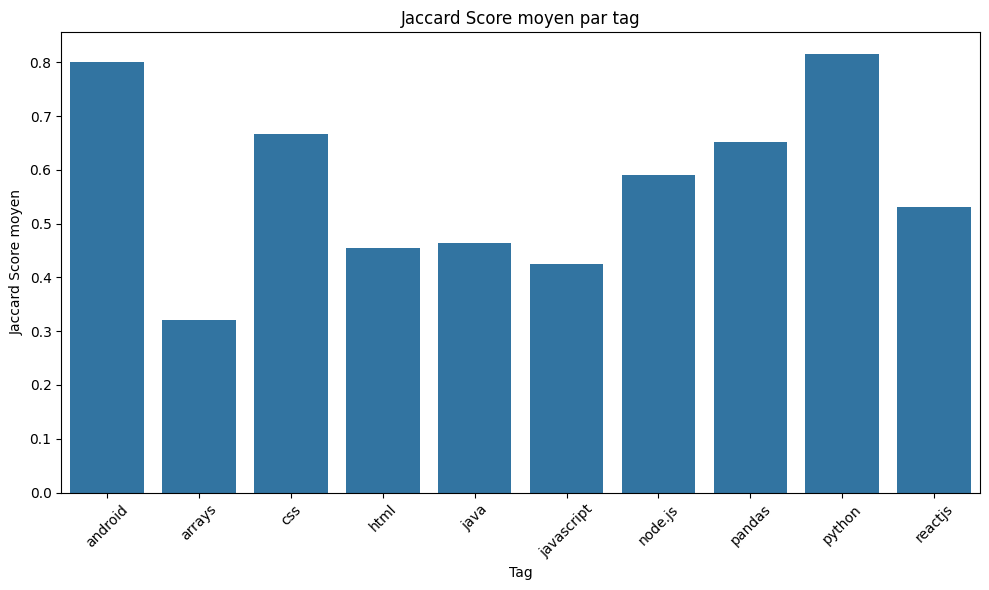

In [111]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt


# Tracé du barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=jaccard_tag_df, x='tag', y='jaccard_score')
plt.title("Jaccard Score moyen par tag")
plt.xlabel("Tag")
plt.ylabel("Jaccard Score moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [112]:
# Sauvegarde des résultats
data.to_pickle("data/results_llm_tags_deepseek14b.pkl")